In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train_dir = '../input/usda-barley/vitamins_detection/vitamins_detection'  
test_dir = '../input/usda-barley/test_data/test_data'
lst = os.listdir(test_dir)

In [3]:

BATCH_SIZE = 32
SEED = 42
IMG_SIZE = (160, 160)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split = 0.2, 
                                                               subset = 'training', batch_size = BATCH_SIZE,
                                                              shuffle = True, image_size = IMG_SIZE, seed = SEED)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split = 0.2, subset = 'validation',
                                                            batch_size = BATCH_SIZE, shuffle = True, 
                                                             image_size = IMG_SIZE, seed = SEED)

Found 8968 files belonging to 5 classes.
Using 7175 files for training.
Found 8968 files belonging to 5 classes.
Using 1793 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['vitaminA', 'vitaminB', 'vitaminC', 'vitaminD', 'vitaminE']

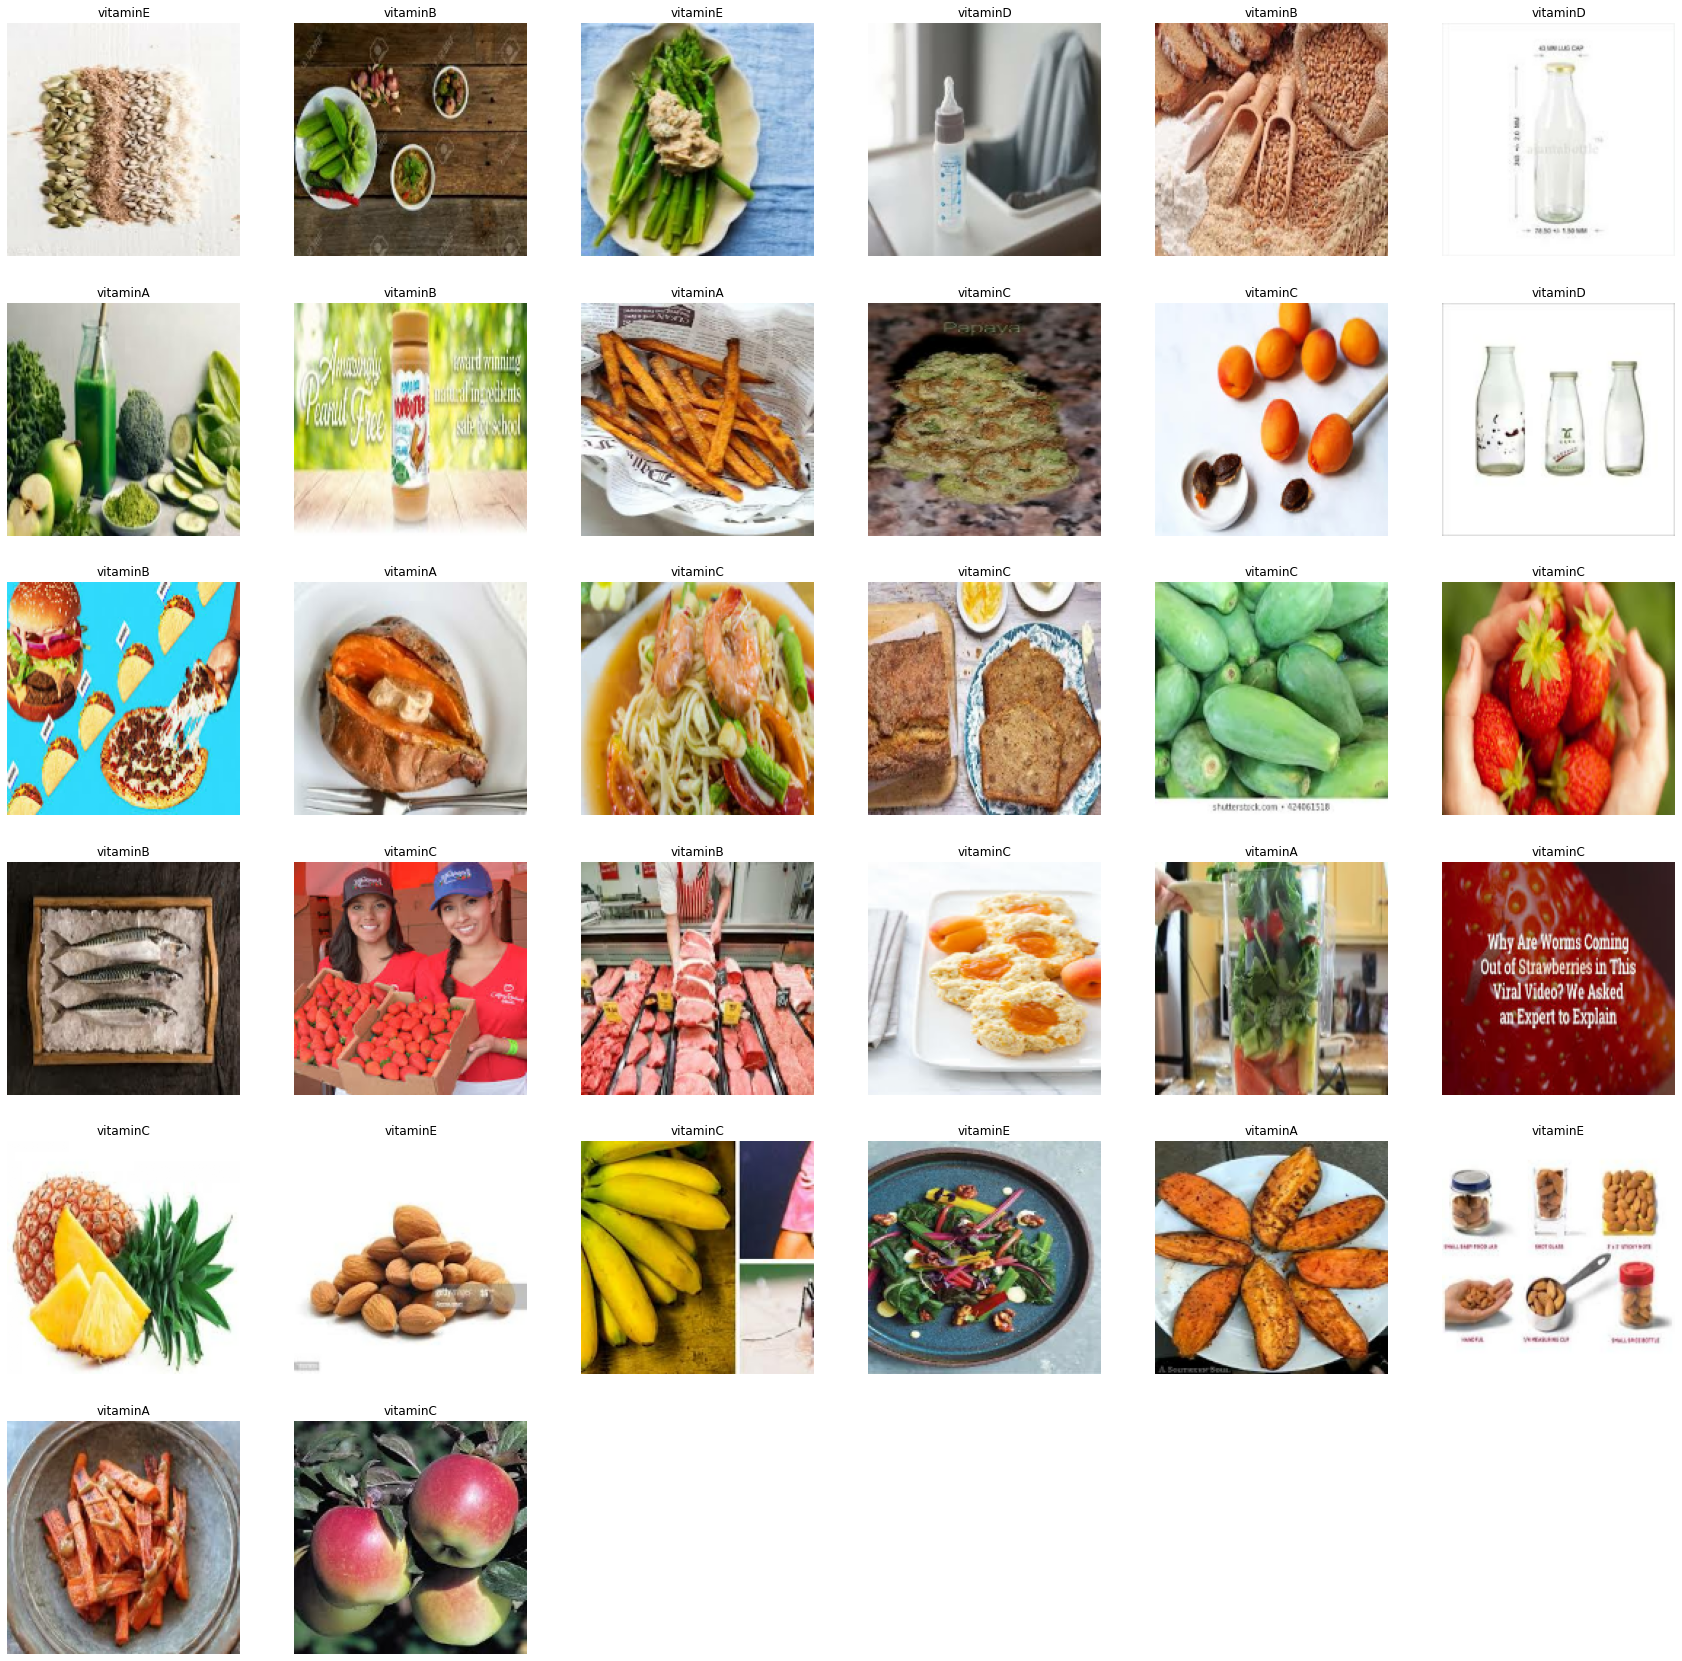

In [5]:
for image, label in train_ds.take(1):
    plt.figure(figsize = (30, 30))
    for i in range(32):
        plt.subplot(6, 6, i+1)
        plt.imshow(image[i]/255.0)
        plt.axis('off')
        plt.title(train_ds.class_names[label[i]])
    plt.show()

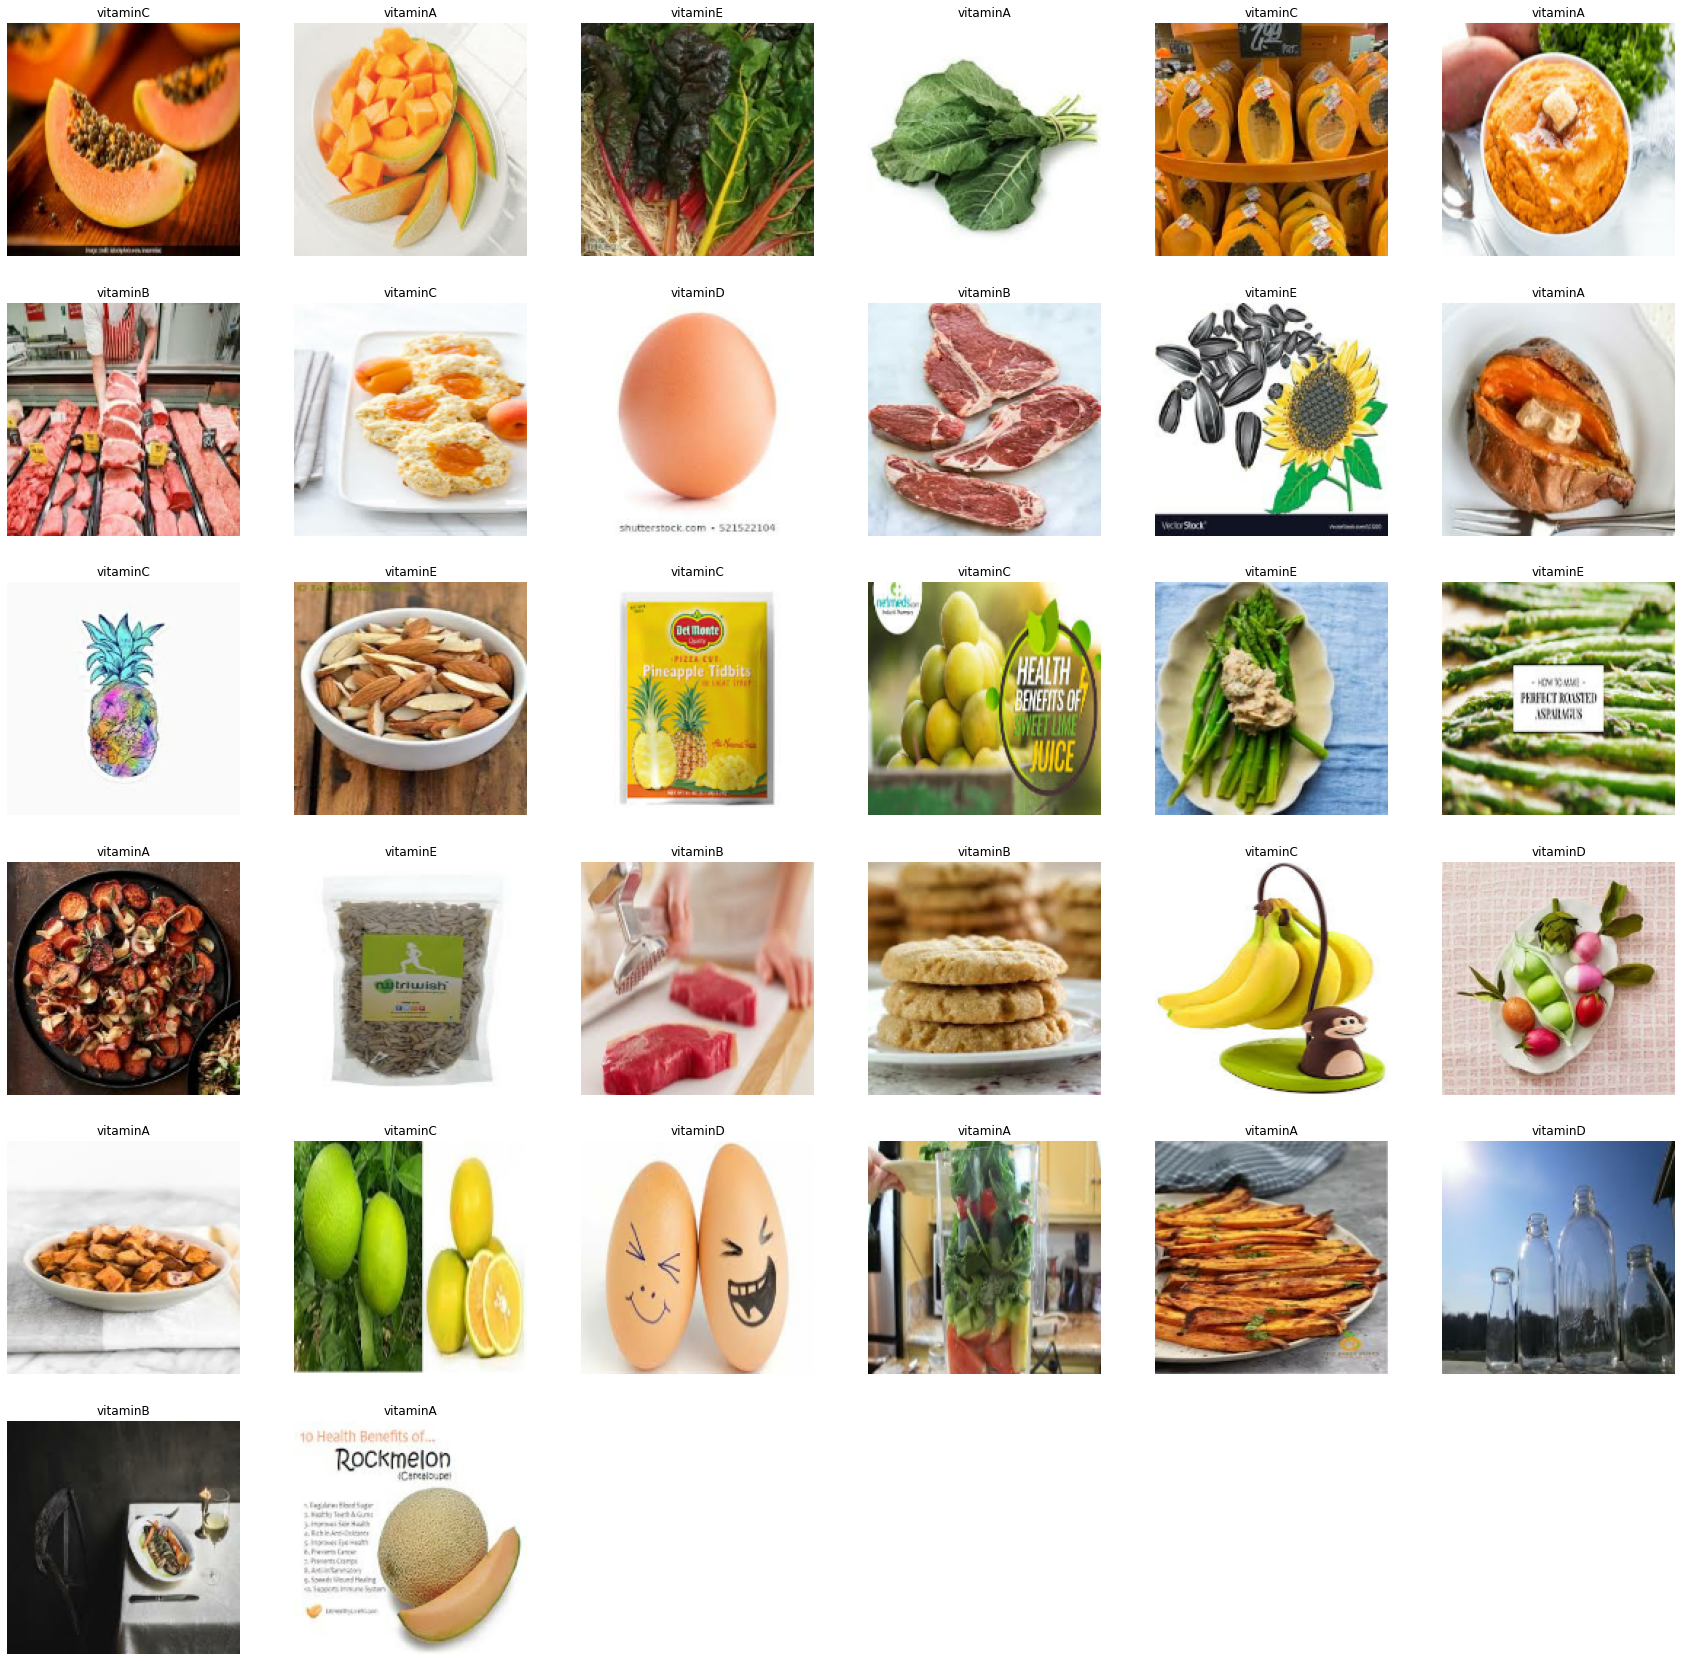

In [6]:
for image, label in train_ds.take(1):
    plt.figure(figsize = (30, 30))
    for i in range(32):
        plt.subplot(6, 6, i+1)
        plt.imshow(image[i]/255.0)
        plt.axis('off')
        plt.title(train_ds.class_names[label[i]])
    plt.show()
    IMG_SHAPE = image.shape

In [7]:
model_pre_pro = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(100, 100),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [8]:
model_agu = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        'horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(160, 160, 3)),
    model_pre_pro,
    model_agu,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(25, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(169, activation = 'sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(119, activation = 'tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(79, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(49, activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'softmax'),
])
 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 141376)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 169)              

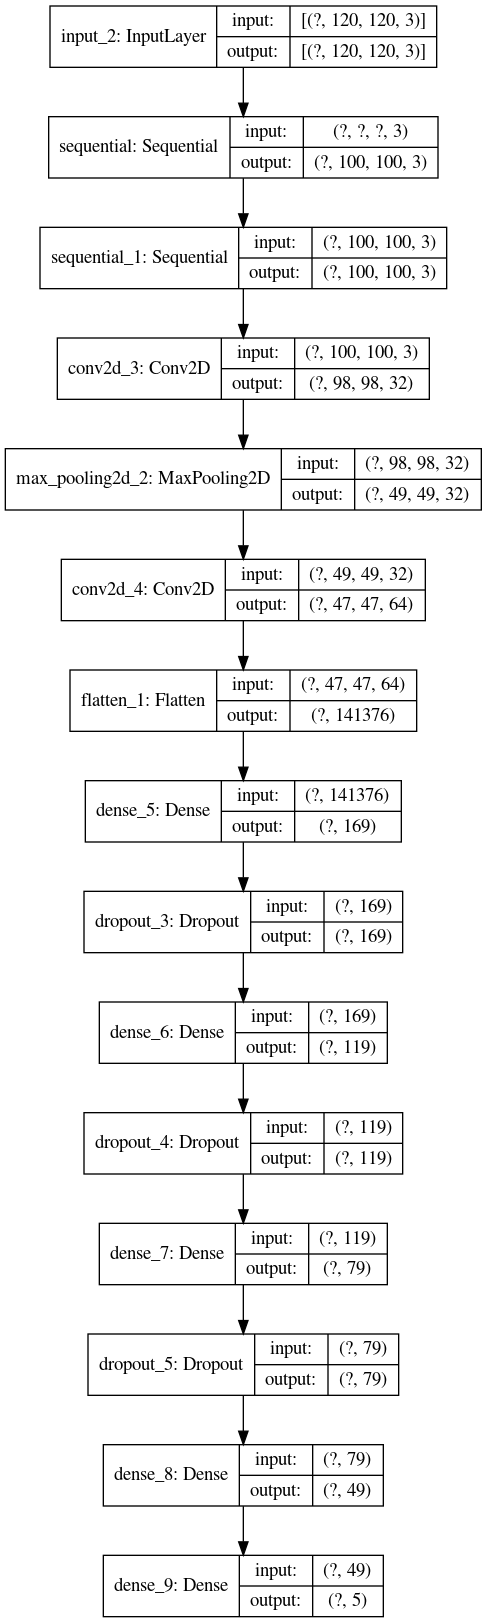

In [15]:
tf.keras.utils.plot_model(model,'abc.png', show_shapes=True, show_layer_names=True)

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [17]:
EPOCHS = 50
hist = model.fit(train_ds, validation_data = val_ds, epochs = EPOCHS, verbose = 1)

Epoch 1/50
225/225 [==============================] - 13s 57ms/step - loss: 1.5701 - accuracy: 0.3332 - val_loss: 1.5519 - val_accuracy: 0.3491
Epoch 2/50
225/225 [==============================] - 12s 53ms/step - loss: 1.5554 - accuracy: 0.3445 - val_loss: 1.5463 - val_accuracy: 0.3491
Epoch 3/50
225/225 [==============================] - 12s 53ms/step - loss: 1.5509 - accuracy: 0.3452 - val_loss: 1.5524 - val_accuracy: 0.3491
Epoch 4/50
225/225 [==============================] - 12s 55ms/step - loss: 1.5483 - accuracy: 0.3455 - val_loss: 1.5470 - val_accuracy: 0.3491
Epoch 5/50
 51/225 [=====>........................] - ETA: 7s - loss: 1.5547 - accuracy: 0.3395

KeyboardInterrupt: 

In [ ]:
model_df=pd.DataFrame(hist.history)
model_df['epoch']=hist.epoch
print(model_df.head())

In [ ]:
plt.plot(model_df['epoch'],model_df['loss'],label='training loss')
plt.plot(model_df['epoch'],model_df['val_loss'],label='validation loss')
plt.legend()

In [ ]:
plt.plot(model_df['epoch'],model_df['accuracy'],label='training accuracy')
plt.plot(model_df['epoch'],model_df['val_accuracy'],label='validation accuracy')
plt.legend()

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)

In [ ]:
(test_loss, test_accuracy)

In [ ]:
pred = []
for f in lst:
    dir_ = os.path.join(test_dir, f)
    img=tf.keras.preprocessing.image.load_img(dir_)
    img=tf.keras.preprocessing.image.img_to_array(img)
    batch_img=tf.expand_dims(img,0) # create a batch
    img1=model_agu(batch_img)
    p = model.predict(img1)
    pred.append(p)

In [ ]:
c = w = 0
for i, p in enumerate(pred):
    if f'vitamin{lst[i][0].upper()}' == class_names[np.argmax(p)]:
        print(f'Actual label is Viamin{lst[i][0].upper()} and Predicted label is {class_names[np.argmax(p)]} --> Correct Prediction is done!')
        c += 1
    else:
        print(f'Actual label is Viamin{lst[i][0].upper()} and Predicted label is {class_names[np.argmax(p)]} --> Wrong Prediction is done!')
        w += 1
print(f'Correct Predictions: {c}\nWorng Predictions: {w}')